In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from matplotlib import pyplot as plt

url = urlopen("https://stepik.org/media/attachments/course/72204/ads.zip")

zipfile = ZipFile(BytesIO(url.read()))
ads_data = pd.read_csv(zipfile.open('ads_data.csv'), header = 0)
ads_data.fillna(0)
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


1. Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям.
Тонкий момент: помните, что некоторые показываемые объявления не кликались, 
и при группировке в таких случаях не будет строк с кликами, а для подсчёта среднего по объявлениям их нужно учитывать.
Округлите ответы до целых чисел.    
Среднее количество кликов на объявление 113.0. Среднее количество показов на объявление 923.0


In [6]:
event_data_table = ads_data.groupby(['ad_id', 'event'], as_index = False).agg({'ad_cost': 'count'})
event_data_table.head()


,ad_id,event,ad_cost
0,2,click,1
1,2,view,101
2,3,click,3
3,3,view,184
4,1902,click,1


In [7]:
event_pivot_table = event_data_table.pivot(index = "ad_id",
                                          columns = 'event',
                                           values = 'ad_cost')\
                                    .fillna(0)
event_pivot_table = event_pivot_table.reset_index()
event_pivot_table 

event,ad_id,click,view
0,2,1.0,101.0
1,3,3.0,184.0
2,1902,1.0,41.0
3,2064,0.0,35.0
4,2132,1.0,58.0
...,...,...,...
960,122004,4.0,100.0
961,122013,0.0,156.0
962,122023,0.0,68.0
963,122031,1.0,138.0


In [8]:
event_pivot_table.mean().round()

event
ad_id    57971.0
click      113.0
view       923.0
dtype: float64

In [9]:
import numpy as np
log_data = event_pivot_table.query('click > 0')
log_data.head()

event,ad_id,click,view
0,2,1.0,101.0
1,3,3.0,184.0
2,1902,1.0,41.0
4,2132,1.0,58.0
6,2494,1.0,324.0


In [10]:
log_data.dtypes

event
ad_id      int64
click    float64
view     float64
dtype: object

4. Найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, 
у которых не было показов (обычное среднее). 
После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.
Вопрос: Какое значение скользящего среднего получим за 6 апреля 2019 года? Округлите ответ до целого числа.


In [11]:

date_table = ads_data.query('event == "view"')\
            .pivot_table(index = 'ad_id',
                         columns = 'date',
                         values = 'time',
                         aggfunc = 'count') 
date_table.dropna()
mean_data = date_table.mean().round()
mean_data

date
2019-04-01    154.0
2019-04-02    138.0
2019-04-03    164.0
2019-04-04    676.0
2019-04-05    919.0
2019-04-06    277.0
dtype: float64

5. Ну а теперь найдём проблемное объявление (с наибольшим/наименьшим количеством показов) в день, в который была замечена самая большая по модулю аномалия. То есть нужно переиспользовать предыдущий датафрейм и найти среди данных рекламы в тот день объявление с наибольшим или наименьшим числом показов.
Потом напишите функцию, которая будет искать такое объявление в датасете.

В ответе укажите id проблемного объявления в день, полученный на предыдущем шаге.

In [24]:
tt = date_table['2019-04-06'].dropna().reset_index()
tt = tt.rename(columns = { '2019-04-06' : 'anomal'})
tt.query('anomal > 100').sort_values('anomal', ascending = False)[:5]

,ad_id,anomal
191,112583,48991.0
65,28142,3280.0
95,38892,1337.0
90,37720,835.0
26,18425,426.0


6. Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

В качестве ответа укажите среднее число дней.

In [25]:
ads_clients = pd.read_csv(zipfile.open('ads_clients_data.csv'), header = 0)
result_data = ads_data.merge(ads_clients.drop(columns = ['date','community_id']))
result_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,anomal,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,NaN,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,NaN,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,NaN,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,NaN,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,NaN,2018-12-04


In [26]:
result_data[['date', 'create_date']] = result_data[['date', 'create_date']].apply(pd.to_datetime)

In [27]:
def find_minimum_diff(group):
    diff = group.date - group.create_date
    return diff.min()

result_data.groupby('client_union_id').apply(find_minimum_diff).mean()

Timedelta('124 days 09:04:43.532219570')

7. Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

Конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов. Например, 1000 клиентов создали кабинет, но лишь 50 из них запустили рекламу. В таком случае конверсия будет равна \frac {50} {1000} \cdot 100 = 5 
1000
50
​	
 ⋅100=5%

Чтобы отобрать данные за нужный промежуток, можно воспользоваться сравнением времени до создания первой рекламы с pd.Timedelta(365, unit='day'))

Ответ дайте в процентах и округлите до сотых

In [28]:
creation = result_data.groupby('client_union_id').apply(find_minimum_diff)
td = pd.Timedelta(365, unit='day')
creation = creation.loc[creation < td]
round(creation.shape[0]/ads_clients.client_union_id.nunique() * 100, 2)

0.69

8. Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков дней для метода pd.cut() – [0, 30, 90, 180, 365]. Создать временные промежутки можно с помощью pd.to_timedelta().

Могут пригодиться:

pd.cut()
value_counts()

In [31]:
value = pd.to_timedelta([0, 30, 90, 180, 365], unit = 'd')
count = pd.cut(creation, bins = value).value_counts()
count

(90 days 00:00:00, 180 days 00:00:00]     396
(30 days 00:00:00, 90 days 00:00:00]      263
(180 days 00:00:00, 365 days 00:00:00]    168
(0 days 00:00:00, 30 days 00:00:00]        11
dtype: int64

9. постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них. Расположите их так, чтобы внизу была самая малочисленная, а наверху – самая большая.

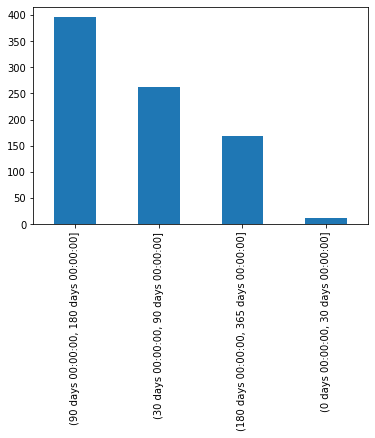

In [33]:
count.plot(kind="bar")

4. 
Скользящее среднее часто используется для поиска аномалий в данных. 
Давайте попробуем нанести на один график значения просто среднего количества показов по дням 
и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).
Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним?
Дни, в которых скользящее среднее равно NaN, не учитываем. Запишите ответ в формате yyyy-MM-dd


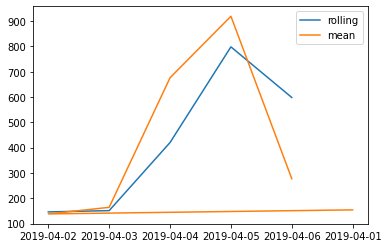

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(data = rolling_data, label = 'rolling')
sns.lineplot(data = mean_data, label = 'mean')
plt.legend()

In [35]:
ads_data['anomal'] = abs(rolling_data - mean_data)
anomal_date = ads_data.loc[ads_data['date'] == '2019-04-06']
anomal_date


,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,anomal
920505,2019-04-06,2019-04-05 21:00:08,view,web,14617,430,14616,CPC,40.3,0,109704,NaN
920506,2019-04-06,2019-04-05 21:00:08,view,android,16359,666,16359,CPM,207.0,0,75733,NaN
920507,2019-04-06,2019-04-05 21:00:08,view,web,17433,1000,17432,CPM,205.0,0,217062,NaN
920508,2019-04-06,2019-04-05 21:00:08,view,web,18425,1494,18424,CPM,208.4,0,42258,NaN
920509,2019-04-06,2019-04-05 21:00:08,view,ios,19317,1752,19309,CPM,200.0,0,52607,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
996385,2019-04-06,2019-04-05 23:59:30,view,android,112583,111818,112260,CPM,210.1,0,22392,NaN
996386,2019-04-06,2019-04-05 23:59:30,click,web,112583,111818,112260,CPM,210.1,0,22392,NaN
996387,2019-04-06,2019-04-05 23:59:30,click,android,112583,111818,112260,CPM,210.1,0,22392,NaN
996388,2019-04-06,2019-04-05 23:59:30,view,android,112583,111818,112260,CPM,210.1,0,22392,NaN
